## Modeling for predicting hospitalization at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [70]:
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from helpers import PlotROCCurve

from dataset_path import output_path

path = output_path
output_path = os.path.join(path, "Figure3")
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed=0

In [71]:
random.seed(random_seed)
np.random.seed(random_seed)

In [72]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 
df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,gender,arrival_transport,disposition,anchor_age,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,183244,14328106,NaN,32336955,2159-11-08 15:13:00,2159-11-09 01:47:00,F,WALK IN,HOME,75,2159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2159,75,False,0 days 10:34:00,NaN,NaN,False,False,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,10.57,NaN,NaN,38.055556,65.0,18.0,100.0,135.0,59.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.444444,53.0,16.0,98.0,130.0,68.0,0.0,5.0,9.0,84.333333,3,9,8,1,1,1
1,376935,18860711,NaN,35614382,2159-10-24 06:19:00,2159-10-24 14:31:00,F,WALK IN,HOME,28,2159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2159,28,False,0 days 08:12:00,NaN,NaN,False,False,False,1,1,1,NaN,NaN,False,0,0,0,0,0,0,8.20,NaN,NaN,36.500000,89.0,18.0,97.0,103.0,46.0,10.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.722222,83.0,16.0,99.0,112.0,51.0,4.0,1.0,5.0,65.000000,0,4,2,1,1,1
2,291579,16860825,NaN,37485359,2203-01-07 17:45:00,2203-01-08 07:00:00,F,AMBULANCE,HOME,52,2194,NaN,NaN,NaN,NaN,BLACK/AFRICAN AMERICAN,NaN,NaN,NaN,2203,61,False,0 days 13:15:00,NaN,NaN,False,False,False,0,0,5,2203-01-12 22:26:00,4 days 15:26:00,False,0,0,2,0,0,0,13.25,NaN,4.64,36.888889,96.0,16.0,96.0,160.0,80.0,9.0,...,0,0,0,1,0,0,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,36.722222,70.0,18.0,98.0,140.0,94.0,3.0,0.0,14.0,106.666667,7,4,3,1,1,1
3,210524,14971343,29116455.0,34783406,2207-07-11 18:24:00,2207-07-11 22:37:00,F,WALK IN,ADMITTED,74,2198,NaN,2207-07-11 20:24:00,2207-07-12 19:15:00,NaN,BLACK/AFRICAN AMERICAN,2207-07-11 18:24:00,2207-07-11 22:37:00,Medicare,2207,83,False,0 days 04:13:00,NaN,NaN,False,True,False,0,0,0,2208-08-28 08:10:00,413 days 09:33:00,False,0,0,0,0,0,0,4.22,NaN,413.40,36.944444,104.0,16.0,100.0,172.0,89.0,0.0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,36.666667,83.0,14.0,99.0,136.0,77.0,0.0,3.0,5.0,116.666667,5,9,8,1,1,2
4,69316,11648387,NaN,39707189,2181-01-23 09:25:00,2181-01-23 13:27:00,M,WALK IN,HOME,64,2175,2183-08-25,NaN,NaN,NaN,WHITE,NaN,NaN,NaN,2181,70,False,0 days 04:02:00,NaN,NaN,False,False,False,0,7,19,2181-01-27 13:02:00,3 days 23:35:00,False,0,2,4,0,0,0,4.03,NaN,3.98,36.333333,118.0,18.0,98.0,166.0,91.0,0.0,...,0,0,0,1,1,1,0,0,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,37.055556,102.0,20.0,99.0,15.0,73.0,0.0,0.0,16.0,116.000000,9,13,9,2,2,3


### 1. Task-specific filter: No task-specific exclusion needed

In [73]:
print('training size =', len(df_train), ', testing size =', len(df_test))

training size = 334480 , testing size = 83620


### 2. Variable Selection

In [74]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_hospitalization"

In [75]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [76]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [78]:
type(y_train.copy().tolist()[0])

bool

In [12]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [15]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.8981573436693093 : 1


### 3.  Modeling script

In [16]:
# Containers for all results
result_list = []

Logistic Regression:


/Users/dominic/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 4.677395343780518 seconds
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
AUC: 0.8043706289743389
AUPRC: 0.7674427397640071
Sensitivity: 0.7381500113759891
Specificity: 0.728888182829131
Score thresold: 0.4543101905660799
2.5 97.5


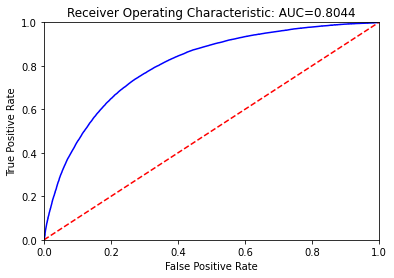

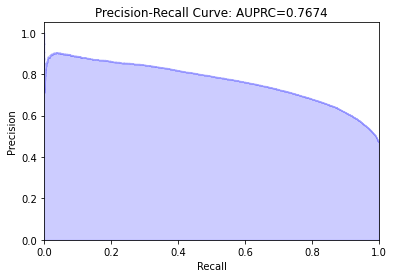

In [50]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
import pickle
with open('task1_logreg.pickle', 'wb') as model_dump:
    pickle.dump(logreg, model_dump)
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



RandomForest:
Training time: 85.64617824554443 seconds
AUC: 0.8188845883428011
AUPRC: 0.7836244230975883
Sensitivity: 0.7356725737543292
Specificity: 0.7501078001951751
Score thresold: 0.5026666666666667
2.5 97.5


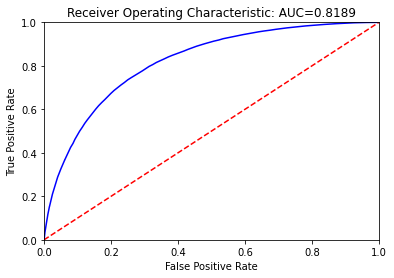

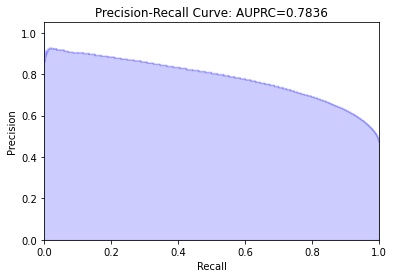

[0.12720715 0.01271496 0.00761734 0.01131148 0.0220492  0.00642565
 0.01406074 0.02854642 0.00077277 0.00197169 0.00505451 0.07860619
 0.08546595 0.0399134  0.04256619 0.08675306 0.08263655 0.04723472
 0.11273314 0.00686493 0.0089689  0.00508821 0.00052081 0.00420339
 0.00276916 0.00383575 0.00415945 0.00348274 0.00415003 0.00339385
 0.00553044 0.00285143 0.00300491 0.00143545 0.00640184 0.00215734
 0.00151119 0.00382977 0.00596824 0.00360383 0.00123102 0.00586731
 0.0044015  0.00145222 0.00198516 0.00105732 0.00786852 0.00277546
 0.00244756 0.00562325 0.01012189 0.00453583 0.00433829 0.00094386
 0.00385833 0.00477192 0.0036528  0.01204512 0.001171   0.00336321
 0.00493607 0.00410286 0.00277026 0.00730648]


In [18]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 74.28271317481995 seconds
AUC: 0.8180776268244039
AUPRC: 0.7918191702711403
Sensitivity: 0.7475794423237354
Specificity: 0.7334952227492454
Score thresold: 0.48359833541134434
2.5 97.5


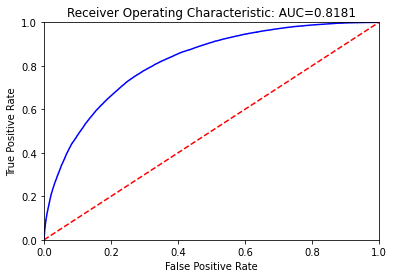

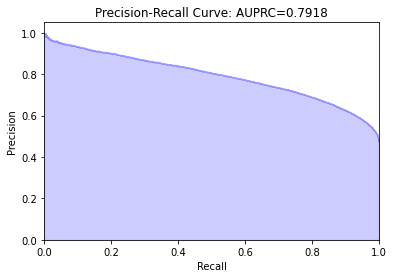

In [19]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [20]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [21]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('hospitalization_triage_mlp')

Epoch 1/20
1673/1673 [==============================] - 4s 2ms/step - loss: 0.5798 - accuracy: 0.7055 - auc: 0.7718 - auprc: 0.7375 - true_positives: 103557.0000 - true_negatives: 132413.0000 - precision: 0.7028 - recall: 0.6543
Epoch 2/20
1673/1673 [==============================] - 3s 2ms/step - loss: 0.5437 - accuracy: 0.7258 - auc: 0.8002 - auprc: 0.7710 - true_positives: 108760.0000 - true_negatives: 134022.0000 - precision: 0.7205 - recall: 0.6872
Epoch 3/20
1673/1673 [==============================] - 3s 2ms/step - loss: 0.5380 - accuracy: 0.7290 - auc: 0.8046 - auprc: 0.7757 - true_positives: 110127.0000 - true_negatives: 133703.0000 - precision: 0.7215 - recall: 0.6958
Epoch 4/20
1673/1673 [==============================] - 3s 2ms/step - loss: 0.5342 - accuracy: 0.7318 - auc: 0.8073 - auprc: 0.7788 - true_positives: 111410.0000 - true_negatives: 133362.0000 - precision: 0.7222 - recall: 0.7039
Epoch 5/20
1673/1673 [==============================] - 3s 2ms/step - loss: 0.5301 -

INFO:tensorflow:Assets written to: hospitalization_triage_mlp/assets


MLP:
2614/2614 [==============================] - 2s 901us/step
AUC: 0.8216359074762665
AUPRC: 0.7941909190041069
Sensitivity: 0.745152564653538
Specificity: 0.7401901822390669
Score thresold: 0.50839263
2.5 97.5


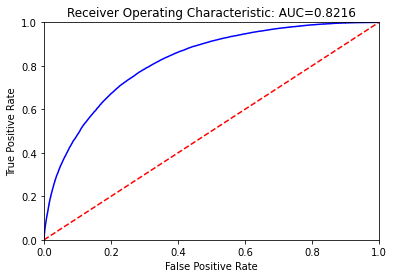

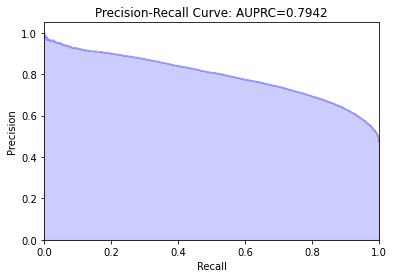

In [22]:
print("MLP:")
mlp = load_model('hospitalization_triage_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [23]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


esi
AUC: 0.7093639144853033
AUPRC: 0.6291459904435645
Sensitivity: 0.5826276006775033
Specificity: 0.7802918548442004
Score thresold: -2.0
2.5 97.5


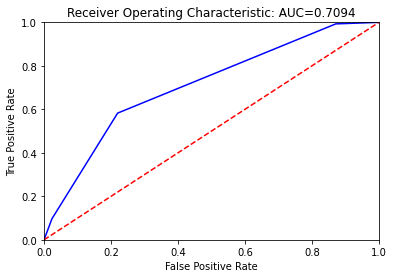

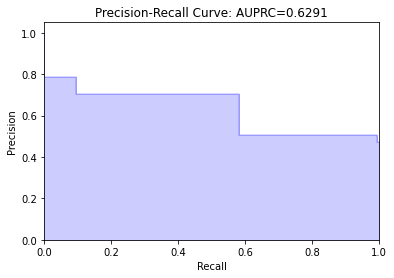

In [24]:
df_test["esi"] = -df_test["triage_acuity"]
get_score_performance("esi", random_seed=random_seed)

In [ ]:
## input AutoScore result from csv (implemented by R, detail: https://github.com/nliulab/AutoScore)
AutoScore_pred = pd.read_csv((os.path.join(path, 'AutoScore_Hospitalization.csv')))
df_test["AutoScore"] = AutoScore_pred["pred_score"]

In [ ]:
get_score_performance("AutoScore", random_seed=random_seed) 

score_NEWS
AUC: 0.5816520390531638
AUPRC: 0.5565045596979793
Sensitivity: 0.5637687387820107
Specificity: 0.5447200599142137
Score thresold: 1.0
2.5 97.5


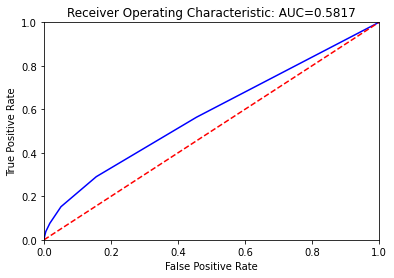

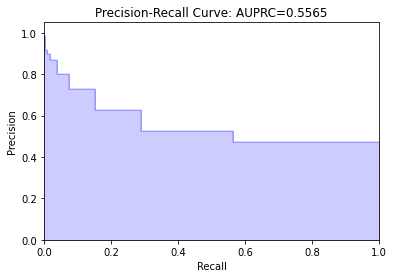

In [27]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.5637469547900328
AUPRC: 0.5389469893400001
Sensitivity: 0.5160654245771924
Specificity: 0.5678460386265121
Score thresold: 1.0
2.5 97.5


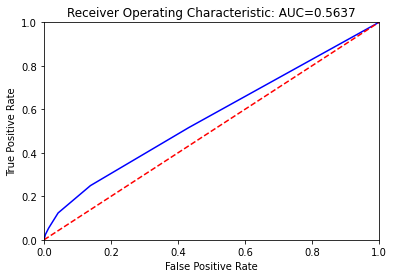

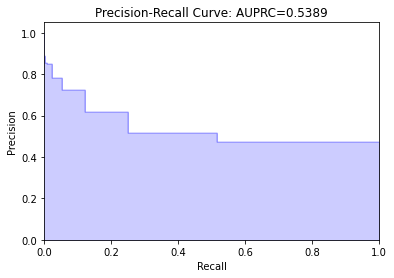

In [28]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.6699430026019431
AUPRC: 0.6068090417710397
Sensitivity: 0.7167125919559117
Specificity: 0.5561809227696707
Score thresold: 3.0
2.5 97.5


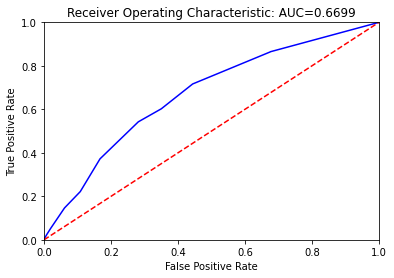

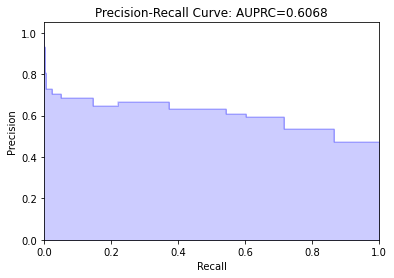

In [29]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.5584163913850305
AUPRC: 0.5218788311407005
Sensitivity: 0.2976969942108856
Specificity: 0.8110432789415156
Score thresold: 2.0
2.5 97.5


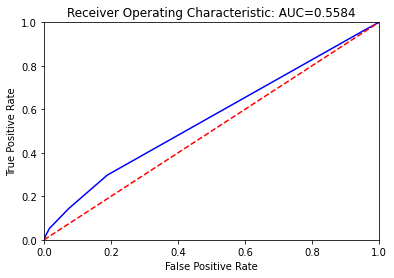

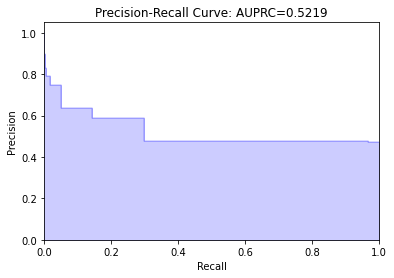

In [30]:
get_score_performance("score_MEWS", random_seed=random_seed)

score_CART
AUC: 0.6734841125719712
AUPRC: 0.6166366820932428
Sensitivity: 0.702024926056071
Specificity: 0.5830742346186142
Score thresold: 4.0
2.5 97.5


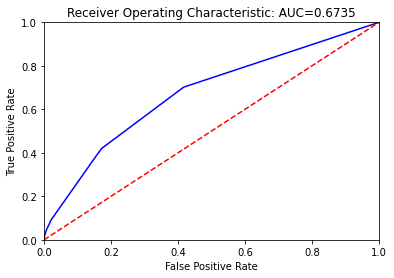

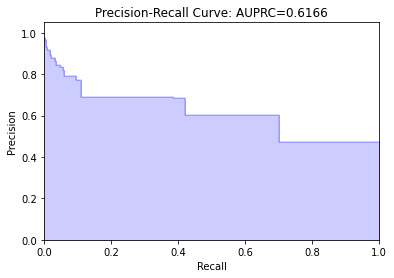

In [31]:
get_score_performance("score_CART", random_seed=random_seed)

In [41]:
import tensorflow.keras as keras
from tensorflow.keras import optimizers, metrics, layers, Model
from tensorflow.keras.optimizers import legacy
from embedding import *

In [42]:
print("Med2Vec:")
version = 'v10'
batch_size=200
vocabulary = vocabulary_map[version]
df_icd_encode = pd.read_csv(os.path.join(path, 'icd_list_dataset_'+version+'.csv'))
df_train_embed = pd.merge(df_train, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')
df_test_embed = pd.merge(df_test, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')

train_gen, test_gen = setup_embedding_data(df_train_embed, df_test_embed, X_train, y_train, X_test, y_test, batch_size)


Med2Vec:


In [ ]:
# To train from scratch, set load_model to None
load_model = None#"embedding_hospitalization_"+version 
save_model = "embedding_hospitalization_"+version

if load_model:
        model = keras.models.load_model(load_model)
else:
        model = create_embedding_model(vocabulary, len(variable))
model.summary()
opt = legacy.Adam(learning_rate=0.001, decay=0.01)
model.compile(loss='binary_crossentropy', 
        optimizer=opt, 
        metrics=['accuracy', 'AUC', {'aucpr': metrics.AUC(name='aucpr', curve='PR')}, 
                    'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
runtime = 1063.299 # to be updated
if not load_model:
        start = time.time()
        model.fit(train_gen, epochs=100, class_weight={1:ratio, 0:1}, verbose=0)
        runtime = time.time()-start
        print('Training time:', runtime, 'seconds')
if save_model:
        keras.models.save_model(model, save_model)
output = model.predict(test_gen)
result = PlotROCCurve(output,y_test, ci=confidence_interval, random_seed=random_seed)

results = ["Med2Vec"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 4. Performance output

In [47]:
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 
                                               'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 
                                               'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity',
                                               'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)

result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task1.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.454,0.804 (0.801-0.806),0.767 (0.762-0.77),0.738 (0.731-0.752),0.729 (0.72-0.737),4.618
1,RF,0.503,0.819 (0.817-0.821),0.784 (0.779-0.787),0.736 (0.733-0.747),0.75 (0.738-0.752),85.646
2,GB,0.484,0.818 (0.816-0.82),0.792 (0.787-0.794),0.748 (0.733-0.755),0.733 (0.728-0.748),74.283
3,MLP,0.508,0.822 (0.819-0.824),0.794 (0.789-0.797),0.745 (0.738-0.764),0.74 (0.724-0.749),62.242
4,esi,-2.000,0.709 (0.706-0.712),0.629 (0.625-0.633),0.583 (0.578-0.587),0.78 (0.777-0.783),0.000
5,score_NEWS,1.000,0.582 (0.579-0.585),0.557 (0.552-0.56),0.564 (0.56-0.566),0.545 (0.541-0.55),0.000
6,score_NEWS2,1.000,0.564 (0.561-0.566),0.539 (0.535-0.543),0.516 (0.512-0.519),0.568 (0.564-0.574),0.000
7,score_REMS,3.000,0.67 (0.665-0.672),0.607 (0.6-0.612),0.717 (0.711-0.72),0.556 (0.553-0.56),0.000
8,score_MEWS,2.000,0.558 (0.557-0.56),0.522 (0.518-0.525),0.298 (0.294-0.3),0.811 (0.809-0.813),0.000
9,score_CART,4.000,0.673 (0.669-0.677),0.617 (0.612-0.621),0.702 (0.697-0.706),0.583 (0.579-0.586),0.000


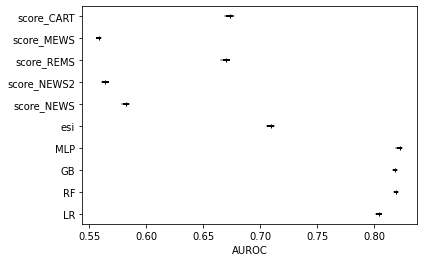

In [48]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
                         my_file = 'AUROC_hosp.eps', my_path = output_path) 

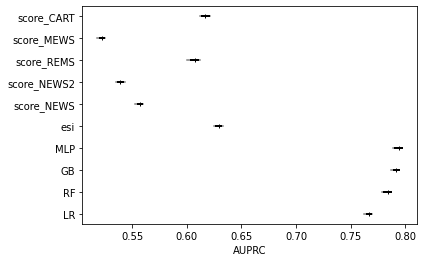

In [49]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
                         my_file = 'AUPRC_hosp.eps', my_path = output_path)

In [39]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_hospitalization_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
0,age,0.127207
18,triage_acuity,0.112733
15,triage_sbp,0.086753
12,triage_heartrate,0.085466
16,triage_dbp,0.082637
11,triage_temperature,0.078606
17,triage_pain,0.047235
14,triage_o2sat,0.042566
13,triage_resprate,0.039913
7,n_hosp_365d,0.028546
